# Mesabi-cam Image Processing Challenge

Let's demonstrate some image processing and parallelism in this notebook.

We have a webcam in our machine room watching as we get ready to install a new system. There's a shared directory where it's been dumping images for the last few months.

In [1]:
%cd /home/support/shared/webcam/filtered/

/panfs/roc/groups/2/support/shared/webcam/filtered


Looks like there about a half-million photos so far. These are probably UNIX timestamps in the filenames.

In [2]:
files = !ls
print len(files)
print files[0:10]
print files[-10:]

12964
['1407423157.jpg', '1407423170.jpg', '1407423178.jpg', '1407423186.jpg', '1407423193.jpg', '1407423200.jpg', '1407423207.jpg', '1407423219.jpg', '1407423227.jpg', '1407423235.jpg']
['1425132920.jpg', '1425132950.jpg', '1425132980.jpg', '1425133010.jpg', '1425133040.jpg', '1425133070.jpg', '1425133100.jpg', '1425133130.jpg', '1425133160.jpg', '1425133190.jpg']


# Setting up and displaying images

First things first, let's load some machinery. IPython has a system for embedding images in notebooks, but for manipulating images we're going to use **scipy**'s ndimage

In [3]:
from IPython.display import display, Image
from scipy import ndimage

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

6201


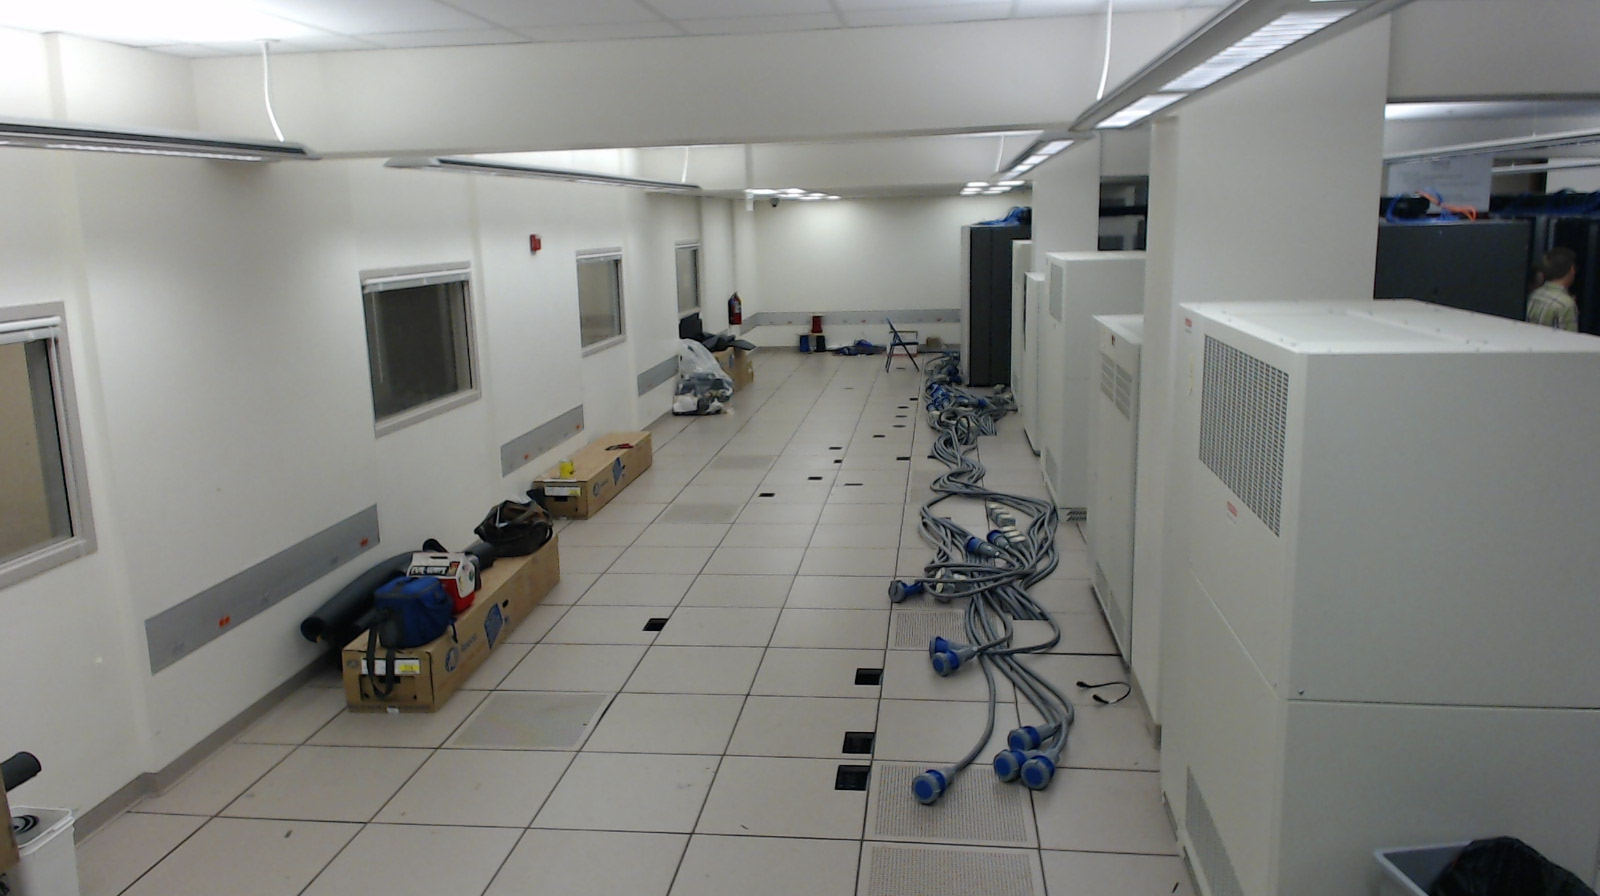

6462


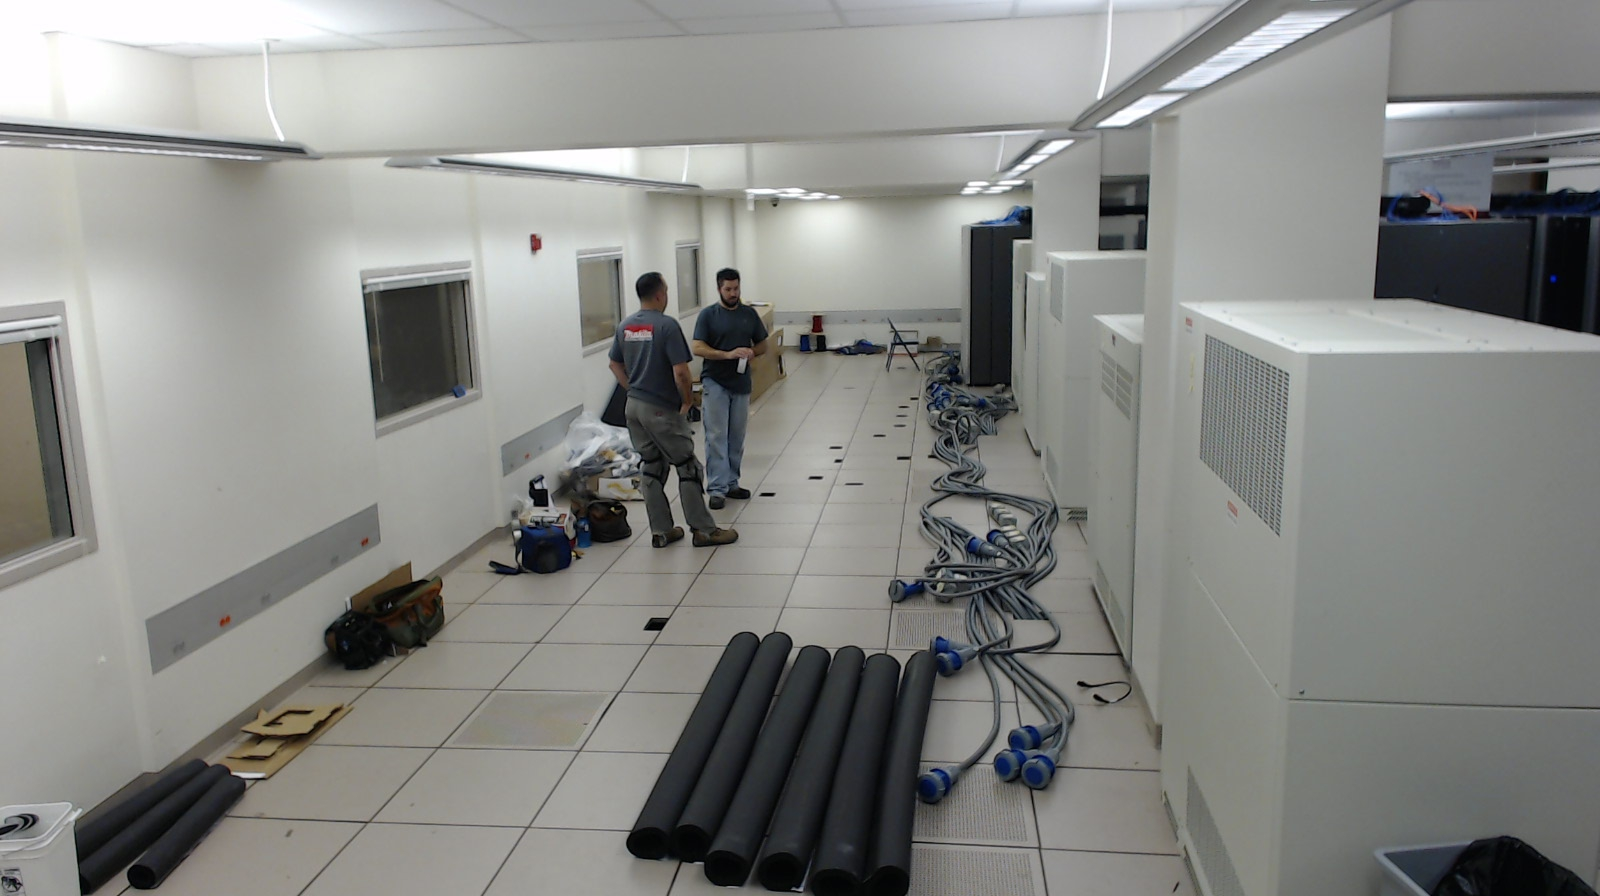

8472


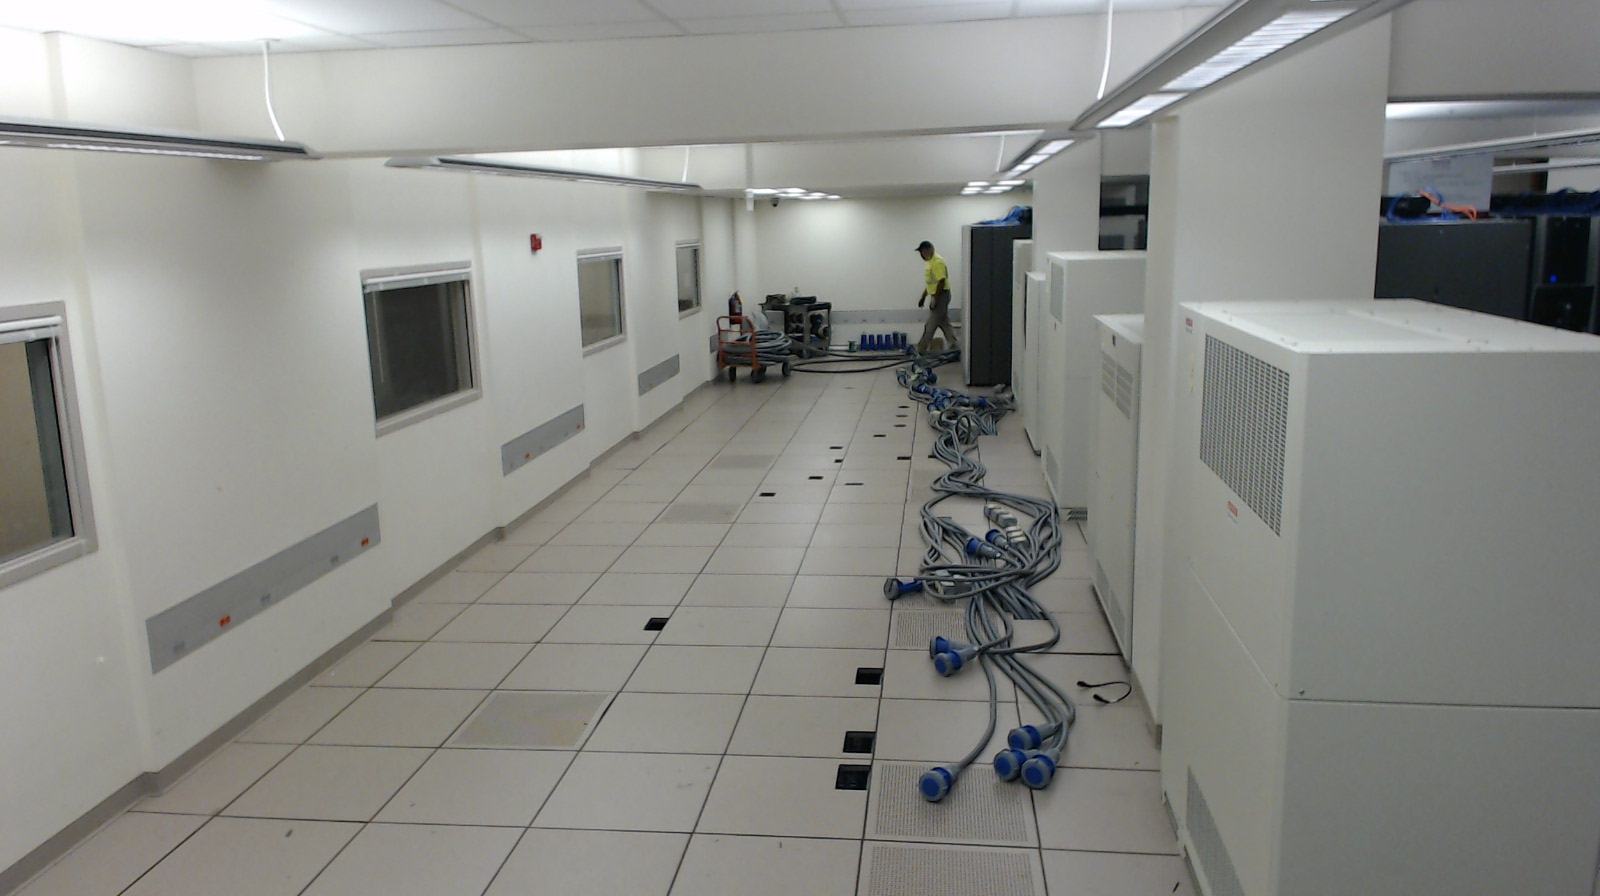

9161


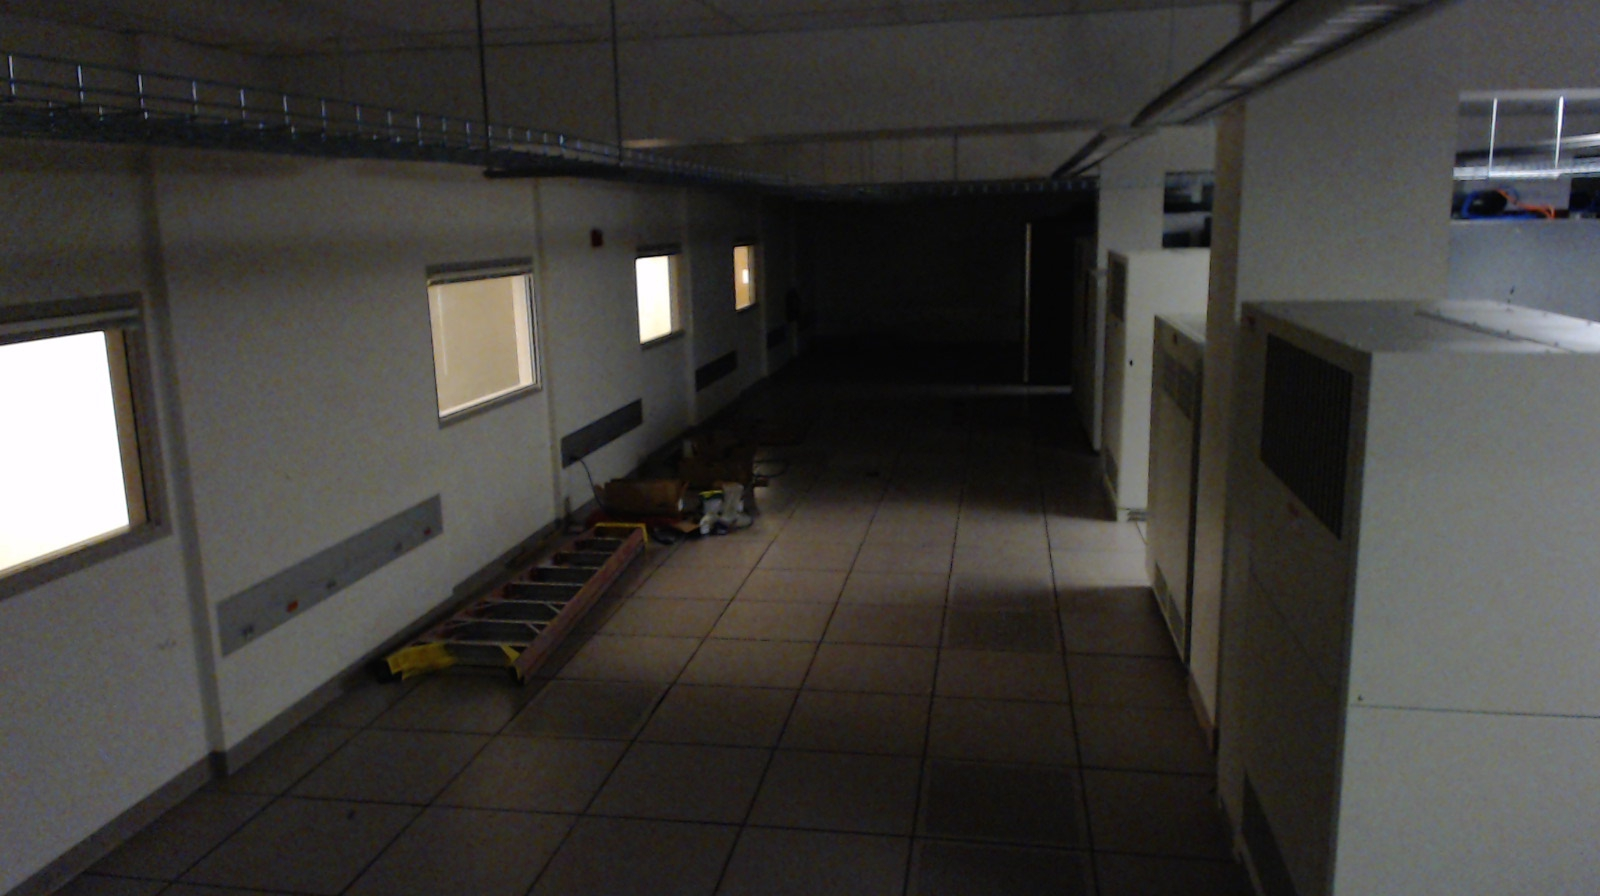

11794


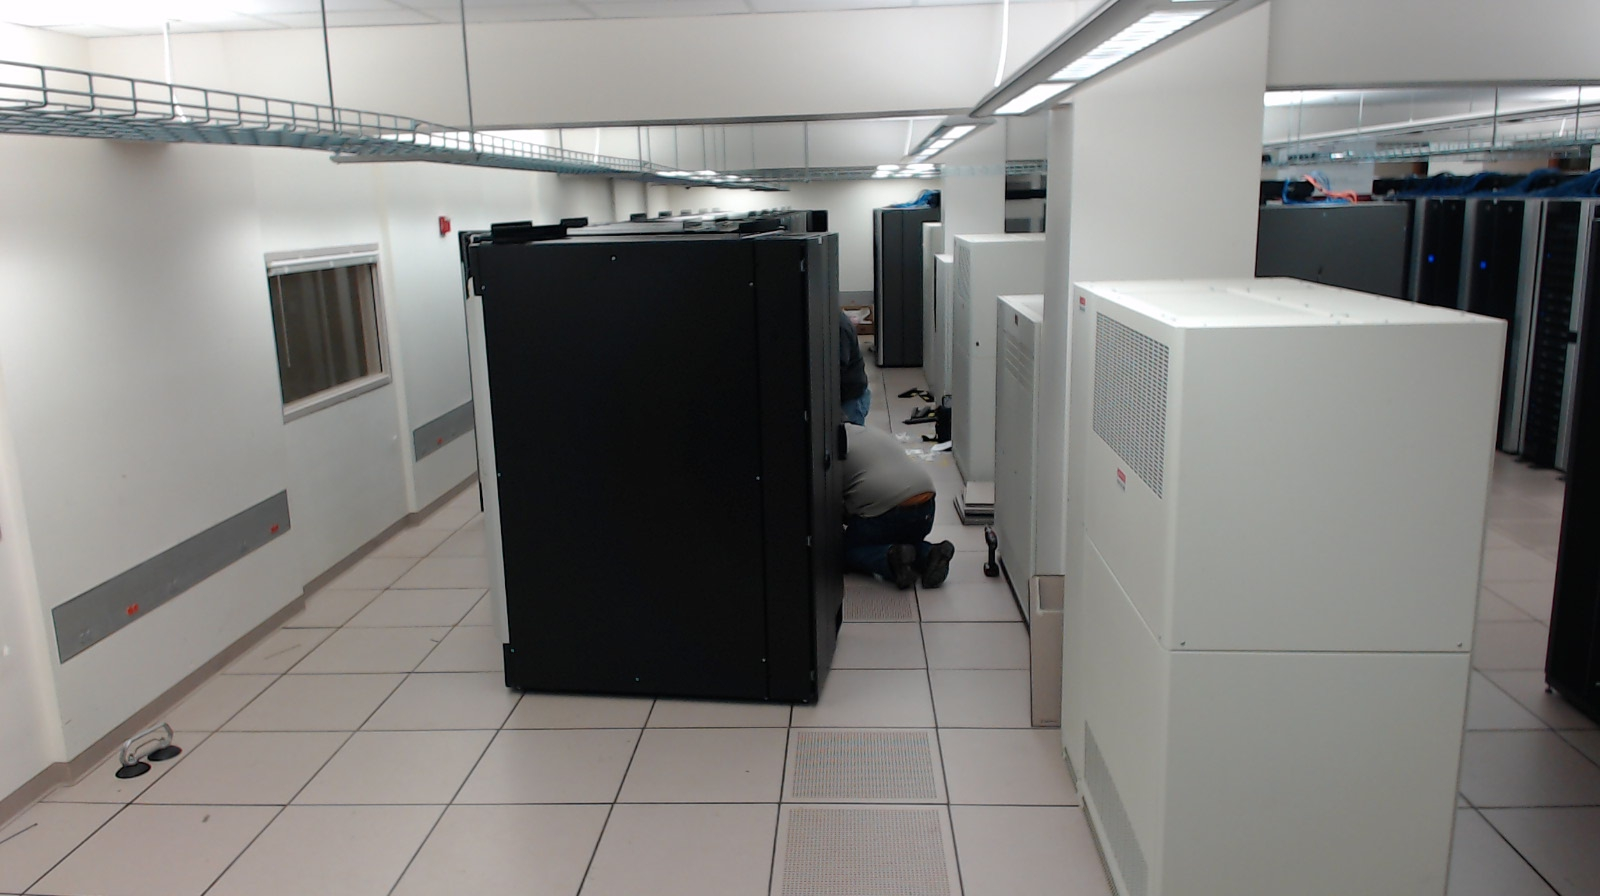

In [5]:
for i in sorted(np.random.random_integers(0, len(files), 5)):
    print i
    display(Image(files[i], width=320))

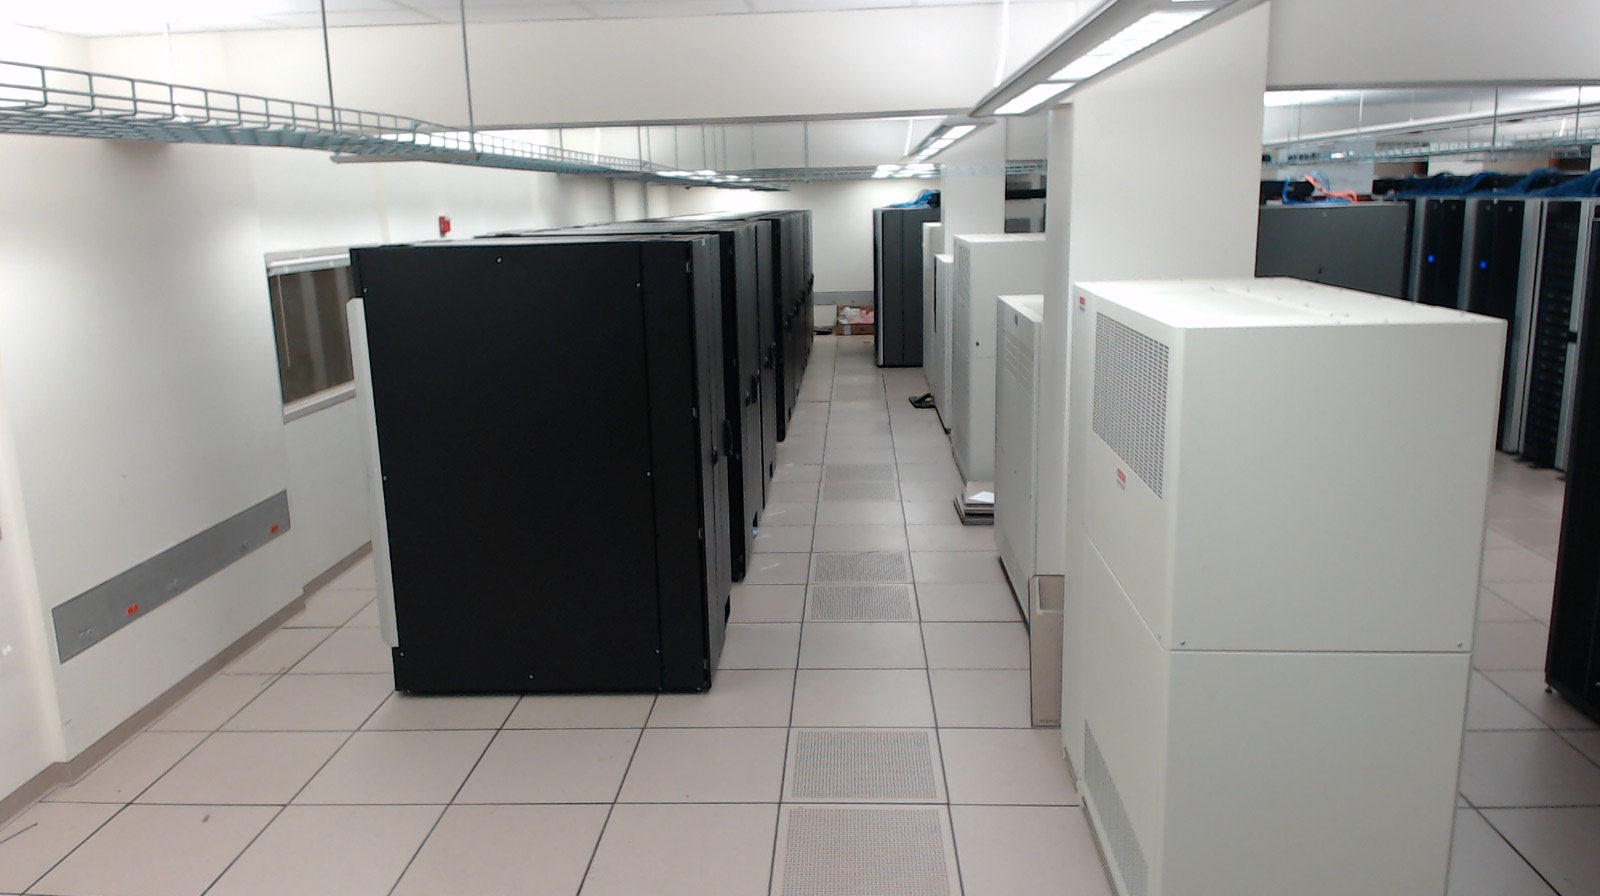

In [6]:
Image(files[-1], width=640)

In [7]:
len(_6.data)

461576

## Imread and imshow

In [8]:
im = ndimage.imread(files[-1])

In [9]:
print im.sum()
print im.mean()
print im.shape

616079518
143.247655785
(896, 1600, 3)


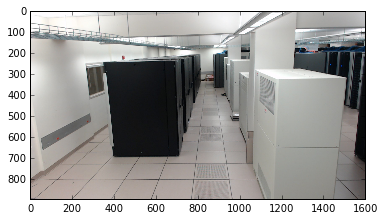

In [10]:
plt.imshow(im)

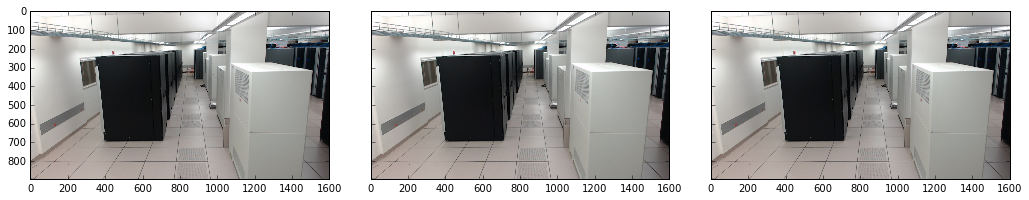

In [11]:
imgs = [ ndimage.imread(f) for f in files[-3:] ]
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(18,3))
fig.subplots_adjust(wspace=0.05)
for im, ax in zip(imgs, axes):
    ax.set_adjustable('box-forced')
    ax.imshow(im, aspect='equal')

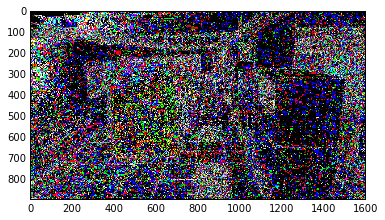

In [12]:
plt.imshow(imgs[1]-imgs[0])

In [13]:
(imgs[1]-imgs[0]).sum()*1.0 / imgs[0].sum()

0.44758166151086748

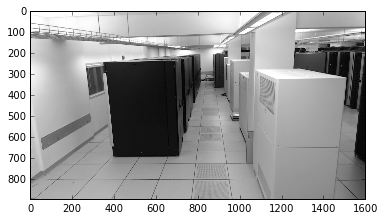

In [14]:
plt.imshow(imgs[0].sum(axis=2), cmap=plt.cm.gray)

## Image processing

Let's set up some functions to compute the luminance and contrast in an image:

In [15]:
def greynorm(im):
    gi = im.sum(axis=2)
    gi = gi / (1.0 * gi.max())
    return gi

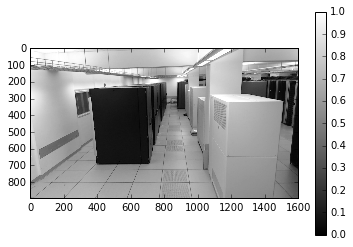

In [16]:
im = plt.imshow(greynorm(imgs[0]), cmap=plt.cm.gray, vmin=0, vmax=1)
plt.colorbar(im)

In [17]:
gi = greynorm(imgs[0])
print gi.min()
print gi.mean()
print gi.std()
print gi.max()
print gi.shape

0.0
0.564914601387
0.24877031274
1.0
(896, 1600)


Okay, so that'll work for a standard function to compare images. We'll use this as the basis for differencing, either between images or when filtering (which is just differencing pixels).

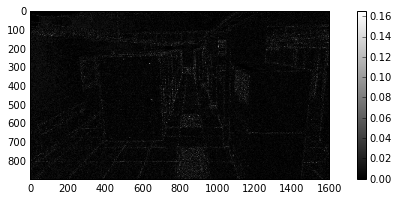

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
im = ax.imshow(np.abs(greynorm(imgs[2]) - greynorm(imgs[0])), cmap=plt.cm.gray)
fig.colorbar(im)

But obviously we'll have to do better if we want to rigorously compare images with different luminance.

Here's how we can find the linear equation that best equalizes two images:

In [19]:
x, y = [imgs[0].ravel(), imgs[1].ravel()]
x.shape

(4300800,)

In [20]:
np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)

(array([ 0.99974224,  0.60045076]),
 array([ 23865369.81423969]),
 2,
 array([ 326547.72896177,     837.30562041]))

We also want to classify these images by contrast, because some are blurrier than others. Here's how we can do that with a Laplace filter:

28455.5660131
0.0198490276319


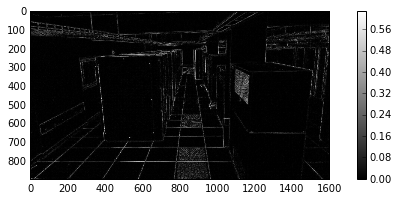

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
edges = np.abs(ndimage.filters.laplace(greynorm(imgs[0])))
im = ax.imshow(edges, cmap=plt.cm.gray)
fig.colorbar(im)
print edges.sum()
print edges.mean()

In [22]:
def lapedges(img):
    import numpy as np
    import scipy.ndimage as ndimage
    return np.abs(ndimage.filters.laplace(greynorm(img)))

In [23]:
imagestats =pd.DataFrame(index=files, columns=['level','contrast'])

In [24]:
imagestats.level = 0.0
imagestats.contrast = 0.0

In [25]:
imagestats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12964 entries, 1407423157.jpg to 1425133190.jpg
Data columns (total 2 columns):
level       12964 non-null float64
contrast    12964 non-null float64
dtypes: float64(2)
memory usage: 303.8+ KB


In [26]:
imagestats.loc[files[0]]

level       0
contrast    0
Name: 1407423157.jpg, dtype: float64

In [27]:
for f in files[0:10]:
    im = ndimage.imread(f)
    imagestats.loc[f] = [ im.mean(), lapedges(im).mean() ]

In [28]:
imagestats.head()

level  contrast
1407423157.jpg  132.710385  0.022327
1407423170.jpg  134.594016  0.022328
1407423178.jpg  134.489503  0.022379
1407423186.jpg  135.714010  0.014904
1407423193.jpg  134.430778  0.022210

135.217190523
0.022109194459


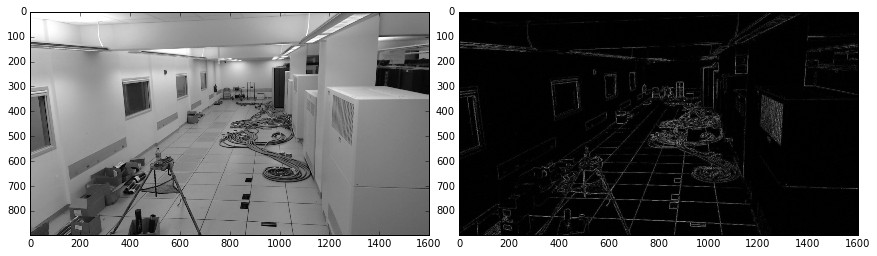

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(greynorm(im), cmap=plt.cm.gray)
ax[1].imshow(lapedges(im), cmap=plt.cm.gray)
print im.mean()
print lapedges(im).mean()

## Parallel computing

Let's look at statistics for large numbers of images now.

In [30]:
24 * 60 * 2 * 7

20160

There should be 2 images per minute coming in, so let's take a look at the past week, or ~20000 images.

First things first, we fire up an IPython parallel cluster. Take a look at [MSI Examples.ipynb](MSI Examples.ipynb) for an example how to set this up.

In [47]:
!qstat -u milligan


mesabim3.msi.umn.edu: 
                                                                                  Req'd       Req'd       Elap
Job ID                  Username    Queue    Jobname          SessID  NDS   TSK   Memory      Time    S   Time
----------------------- ----------- -------- ---------------- ------ ----- ------ --------- --------- - ---------
2021226.mesabim3.msi.u  milligan    small    jupyterhub-singl   6476     1      2       4gb  08:00:00 R  00:14:35
2021258.mesabim3.msi.u  milligan    small    ipcluster         17166     1     24       --   01:00:00 R  00:06:13


We're setting up an 8-node cluster of engines, for 64 total workers.

In [48]:
import ipyparallel as parallel
clients = parallel.Client()
print clients.ids

IOError: Connection file '/panfs/roc/groups/2/support/milligan/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

And in addition to the direct engines view, we'll set up a load-balanced interface for the parallel map commands.

In [33]:
lv = clients.load_balanced_view()
lv.block = False

In [34]:
def statimg(f):
    import scipy.ndimage as ndimage
    im = ndimage.imread(f)
    return [ f, im.mean(), lapedges(im).mean() ]

In [35]:
%%px
%cd /home/support/shared/webcam/filtered/

[stdout:0] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:1] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:2] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:3] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:4] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:5] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:6] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:7] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:8] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:9] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:10] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:11] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:12] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:13] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:14] /panfs/roc/groups/2/support/shared/webcam/filtered
[stdout:15] /panfs/roc/groups/2/support/shared/webcam/filtered
[s

Note the workers don't inherit our environment by default, and the parallel map is only going to push the function definition of the mapped function. So we need to inject these definitions ourselves.

Notice that we also stashed the import statements in the function definitions. Imports are free after the first time, so this is one of the more convenient ways to ensure they happen.

In [36]:
clients[:]['greynorm'] = greynorm
clients[:]['lapedges'] = lapedges

For comparison, how quickly can we digest a few files locally?

In [37]:
%time statimg(files[100])

CPU times: user 95 ms, sys: 26 ms, total: 121 ms
Wall time: 123 ms


['1407503540.jpg', 127.69647321428572, 0.020207674997082169]

So let's dispatch some work!

In [38]:
result = lv.map(statimg, files)

In [41]:
result.progress

10128

We could probably make a nice HTML widget that would poll result.progress and give us a progress bar. But we'll save that for another demo.

In [42]:
result.progress

12964

In [43]:
result.ready()

True

In [44]:
result.serial_time

1812.0079300000034

Yay for not having to wait around 30 minutes for this to finish!

In [45]:
result[0:10]

[['1407423157.jpg', 132.71038481212798, 0.022327032635971061],
 ['1407423170.jpg', 134.59401553199405, 0.022327824098389359],
 ['1407423178.jpg', 134.48950288318451, 0.02237861993755836],
 ['1407423186.jpg', 135.71400995163691, 0.014904189279878615],
 ['1407423193.jpg', 134.43077776227679, 0.02221044876283847],
 ['1407423200.jpg', 135.30306384858631, 0.022289598651960795],
 ['1407423207.jpg', 127.6579517764137, 0.021753490458683467],
 ['1407423219.jpg', 120.96086611793154, 0.02120677229225024],
 ['1407423227.jpg', 134.33613792782739, 0.022079917644140992],
 ['1407423235.jpg', 135.21719052269344, 0.022109194459033612]]

In [46]:
len(result)

12964

In [69]:
print result[0]
print result[1000:1005]
print result[-1]

['1407423157.jpg', 132.71038481212798, 0.022327032635971061]
[['1407773570.jpg', 142.35637718563987, 0.021245329642273585], ['1407773600.jpg', 143.5404808407738, 0.0077716193248132609], ['1407773630.jpg', 141.9800404575893, 0.021281727795284786], ['1407773660.jpg', 122.52712681361608, 0.019822251035831], ['1407773690.jpg', 131.39474493117561, 0.020500370200163393]]
['1425133190.jpg', 143.24765578497025, 0.019763916243580763]


But...

In [72]:
result[0]

['1407423157.jpg', 132.71038481212798, 0.022327032635971061]

In [73]:
for t in result:
    f, l, c = t
    imagestats.loc[f] = [l,c]

Okay, so some subset of these results failed. But let's figure out which ones and keep the good data.

In [122]:
for i in xrange(len(result)):
    try:
        f, l, c = result[i][0]
        imagestats.loc[f] = [l,c]
    except:
        print "Failure for result", i, "maybe ", files[i]

Failure for result 10804 maybe  1407655880.jpg


In [74]:
imagestats.tail()

level  contrast
1425133070.jpg  136.290666  0.019665
1425133100.jpg  135.311443  0.019637
1425133130.jpg  144.053223  0.019849
1425133160.jpg  144.616543  0.019859
1425133190.jpg  143.247656  0.019764

Obviously that mostly worked. Let's check the table...

In [127]:
imagestats[-20000:][imagestats.level == 0.0]

level  contrast
1425024166.mp4      0         0

Interesting, betting that's the one that failed. Not too surprising, guess we should have filtered for JPEGs first.

In [130]:
imagestats[-20000:].describe()

level      contrast
count  20000.000000  20000.000000
mean     105.425618      0.014497
std       35.002794      0.004482
min        0.000000      0.000000
25%       63.532352      0.011558
50%      104.383998      0.012802
75%      136.258114      0.019529
max      250.953397      0.025785

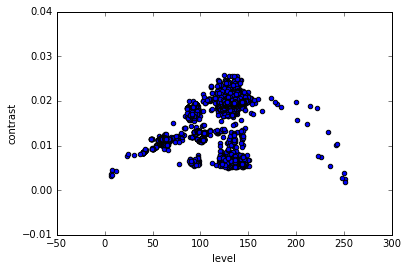

In [75]:
imagestats[-20000:].plot(x='level', y='contrast', kind='scatter')

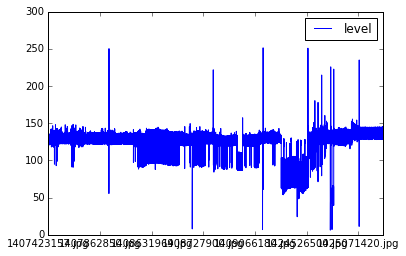

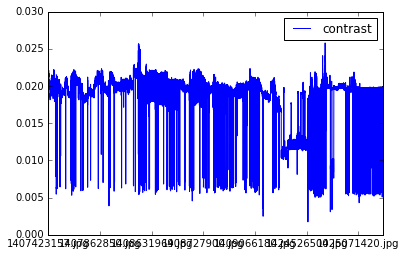

In [76]:
imagestats[-20000:].plot(y='level')
imagestats[-20000:].plot(y='contrast')